In [13]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from catboost import CatBoostRegressor
import os
import pickle
import datetime

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [14]:
df = pd.read_csv('file_csv/rentcar/car_data.csv')

display(df)

,date,name,type,seater,m_year,price,label
0,2023-08-01,모닝 어반 (만26세),휘발유,5인승,2021~22년형,80000,완전자차포함
1,2023-08-01,쏘나타뉴라이즈 (만26세),LPG,5인승,2017~18년형,81400,완전자차포함
2,2023-08-01,올뉴아반떼,휘발유,5인승,2020~22년형,87220,완전자차포함
3,2023-08-01,올뉴아반떼 (만26세),휘발유,5인승,2020~21년형,87220,완전자차포함
4,2023-08-01,2022 올뉴K3,휘발유,5인승,2022년형,87220,완전자차포함
...,...,...,...,...,...,...,...
34435,2023-10-23,포르쉐 카이엔 쿠페 하이브리드,하이브리드,5인승,2021년형,0,마감
34436,2023-10-23,포르쉐 파나메라,휘발유,4인승,2021년형,0,마감
34437,2023-10-23,2021 포르쉐 타이칸,전기,4인승,2021년형,0,마감
34438,2023-10-23,2018 더뉴스타렉스어반 9인승,경유,9인승,2018~19년형,0,마감


In [15]:
print(df['label'].unique())

['완전자차포함' '자차미포함' '마감']


In [16]:
df['name'] = df['name'].str.replace(r'\s*\([^)]*\)', '', regex=True).copy()
pattern = r'\d{4}'
df['name'] = df['name'].apply(lambda x: re.sub(pattern, '', x)).str.strip().copy()
pattern = r'\s\d+인승'
df['name'] = df['name'].apply(lambda x: re.sub(pattern, '', x)).copy()
df = df[~df['name'].str.contains('/')].copy()
df = df[~df['type'].str.contains('/')].copy()
df['m_year'] = df['m_year'].apply(lambda x: int(x[:4])).copy()
df['seater'] = df['seater'].apply(lambda x: int(re.findall(r'\d+', x)[0])).copy()

df['year_model'] = 2023 - df['m_year']

df['name'] = df['name'].replace('K5 DL3', '3세대 K5')
df['name'] = df['name'].replace('올뉴카니발리무진', '올뉴카니발')
df['name'] = df['name'].replace('4세대쏘렌토', '4세대 쏘렌토')
df['name'] = df['name'].replace('올뉴아반떼 LPG', '올뉴아반떼')
# 국산차와 외제차 구분하여 'origin' 컬럼 추가
def classify_origin(name):
    korean_cars = ['모닝 어반', '쏘나타뉴라이즈', '올뉴아반떼', '올뉴K3', '더뉴레이', '쏘나타 DN8', 'i30', '더뉴모닝',
    '베뉴', '3세대 K5', '쏘울 부스터', '올뉴카니발', '더뉴스타렉스', '더뉴K5', '더뉴스타렉스어반',
    '더뉴카니발', '코란도', '코나 일렉트릭', 'LF쏘나타', '캐스퍼', '쏘나타 디 엣지', '올뉴K5', '쏘나타', 'K5',
    'QM6 LPE', '4세대 투싼', '올뉴쏘렌토', '토레스', '티볼리에어', '디올뉴스포티지', '4세대카니발', '스타리아',
    '4세대 쏘렌토', 'QM6', '더뉴싼타페', '아반떼', 'K8', '그랜드스타렉스', '디올뉴그랜저',
    '싼타페TM', '셀토스', '팰리세이드2.2', '팰리세이드3.8', '아이오닉5', '더뉴모하비', '더뉴카니발리무진',
    'EV6', '더뉴팰리세이드', '제네시스 GV70', '제네시스 G80', '더뉴카니발 하이리무진', '더 K9', '올뉴제네시스 G80',
    '쏘렌토', '제네시스 GV80', '스토닉', '코나', '그랜저IG', 'K7 프리미어', '더뉴그랜저', '올뉴K7', '스포티지 더볼드',
    '베리뉴 티볼리', '쏠라티', '스타렉스 하이리무진', '모하비더마스터', '올뉴모닝', '레이', 'XM3',
    '스포티지더볼드', 'SM6', '투싼', '디 올뉴코나', '아이오닉6', '올뉴투싼', '제네시스 G70',
    '더뉴아반떼', '니로', '아이오닉EV', '올뉴스포티지', '뉴K3', '티볼리아머', '스포티지', '아반떼AD', '엑센트', 'K7', '뉴SM3 ZE'
]
    if name in korean_cars:
        return '국산차'
    else:
        return '외제차'

df['made'] = df['name'].apply(classify_origin)

# 각 크기에 해당하는 자동차 모델들의 리스트
경차_list = ['모닝 어반', '더뉴레이', '더뉴모닝', '캐스퍼', '올뉴모닝', '더넥스트스파크']
소형차_list = ['미니쿠퍼컨버터블 S', '미니쿠퍼컨버터블', '볼트EV', '미니클럽맨', '엑센트']
소형SUV_list = ['베뉴', '코나 일렉트릭', '트레일블레이저', '티볼리에어', '셀토스', '스토닉', '코나', '베리뉴 티볼리', '티볼리아머', '레이', 'XM3', '디 올뉴코나', '니로', '쏘울 부스터']
중형차_list = ['쏘나타뉴라이즈', '쏘나타 DN8', '3세대 K5', '더뉴K5', 'LF쏘나타', '쏘나타 디 엣지', '올뉴K5', '쏘나타', 'K5', '제네시스 G70', '아이오닉6', '벤츠 C클래스 카브리올레', '벤츠 E250 아방가르드', '아우디 A5 카브리올레', 'BMW 520i', '벤츠 E220d 카브리올레', 'SM6', '테슬라 모델3']
중형SUV_list = ['토레스', '올뉴쏘렌토', 'QM6 LPE', '디올뉴스포티지', '4세대 쏘렌토', 'QM6', '더뉴싼타페', '싼타페TM', '아이오닉5', 'EV6', '제네시스 GV70', '쏘렌토', '스포티지 더볼드', '올뉴스포티지', '스포티지', '스포티지더볼드', '투싼', '4세대 투싼', '올뉴투싼', '볼보 XC40']
대형차_list = ['더 K9']
대형SUV_list = ['모하비더마스터', '더뉴모하비', '벤츠 G클래스 AMG', '쉐보레 트래버스', '팰리세이드2.2', '더뉴팰리세이드', '올뉴카니발', '더뉴카니발', '4세대카니발', '팰리세이드3.8', '더뉴카니발리무진', '더뉴카니발 하이리무진']
준중형_list = ['올뉴아반떼', '올뉴K3', 'i30', '코란도', '아반떼', 'BMW 430i 컨버터블', '더뉴아반떼', '아반떼AD', '아이오닉EV', '뉴K3', '뉴SM3 ZE', '폭스바겐 제타']
준대형_list = ['K8', '디올뉴그랜저', '제네시스 G80', '올뉴제네시스 G80', '제네시스 GV80', '그랜저IG', 'K7 프리미어', '더뉴그랜저', '올뉴K7', 'K7']
스포츠카_list = ['BMW Z4', '포르쉐 718 박스터', '포드 머스탱컨버터블', 'BMW 428i 컨버터블', 'BMW 420i 컨버터블']
승합차_list = ['스타리아', '쏠라티', '더뉴스타렉스', '더뉴스타렉스어반', '그랜드스타렉스', '스타렉스 하이리무진']

# 새로운 컬럼 추가하여 카테고리 기입
df['category'] = '기타'
df.loc[df['name'].isin(경차_list), 'category'] = '경차'
df.loc[df['name'].isin(소형차_list), 'category'] = '소형차'
df.loc[df['name'].isin(소형SUV_list), 'category'] = '소형SUV'
df.loc[df['name'].isin(중형차_list), 'category'] = '중형차'
df.loc[df['name'].isin(중형SUV_list), 'category'] = '중형SUV'
df.loc[df['name'].isin(대형차_list), 'category'] = '대형차'
df.loc[df['name'].isin(대형SUV_list), 'category'] = '대형SUV'
df.loc[df['name'].isin(준중형_list), 'category'] = '준중형'
df.loc[df['name'].isin(준대형_list), 'category'] = '준대형'
df.loc[df['name'].isin(스포츠카_list), 'category'] = '스포츠카'
df.loc[df['name'].isin(승합차_list), 'category'] = '승합차'


grouped = df.groupby(['date', 'name'])
df['r_rate'] = grouped['label'].transform(lambda x: (x == '마감').sum() / x.count())

df = df[df['label'] != '마감']

def assign_value_based_on_range(val):
    if 0 <= val < 0.25:
        return 1
    elif 0.25 <= val < 0.5:
        return 2
    elif 0.5 <= val < 0.75:
        return 3
    elif 0.75 <= val <= 1:
        return 4
    else:
        return None
    
df['r_rate'] = df['r_rate'].apply(assign_value_based_on_range)
df.loc[:, 'r_rate'] = df['r_rate']


def rentcar_EDA(file):

    # 결측치 및 중복값 삭제
    df = file.dropna()
    df = df.drop_duplicates()

    # 요일 컬럼 생성
    df['date'] = pd.to_datetime(df['date'])
    dateDict = {0:"월요일", 1:"화요일", 2:"수요일", 3:"목요일", 4:"금요일", 5:"토요일", 6:"일요일"}   

    def day_output(date):
        return dateDict[date.weekday()]
    
    df['day'] = df['date'].apply(day_output)

    # 주말 / 공휴일 컬럼 생성
    holiday_list = ['2023-08-15', '2023-09-28', '2023-09-29', '2023-09-30', '2023-10-03', '2023-10-09']
    weekends_list = ['금요일', '토요일', '일요일']


    def day_off(row):
        date = pd.to_datetime(row['date']).strftime('%Y-%m-%d')  # 날짜 형식을 통일하기 위해 문자열로 변환
        if date in holiday_list:
            return '공휴일'
        elif row['day'] in weekends_list:
            return '주말'
        else:
            return '평일'
    

    df['holiday'] = df.apply(day_off, axis=1)

    df = df.drop(df[df['price'] == 0].index)
    return df

df = rentcar_EDA(df)

# 'date' 컬럼을 날짜 데이터로 변환
df['date'] = pd.to_datetime(df['date'])

# 각 날짜 정보를 컬럼으로 바꾸기
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['days'] = df['date'].dt.day

def set_peak_season(month, date):
    date_str = date.strftime('%Y-%m-%d')
    if month == 8 and date_str < '2023-08-15':
        return '성수기'
    elif date_str in ['2023-09-26','2023-09-27','2023-09-28', '2023-09-29', '2023-09-30', '2023-10-01', '2023-10-02','2023-10-06', '2023-10-07','2023-10-08' '2023-10-09']:
        return '성수기'
    else:
        return '비수기'

df['peak_season'] = df.apply(lambda row: set_peak_season(row['month'], row['date']), axis=1)
df.reset_index(drop=True, inplace=True)
display(df)

/var/folders/5x/8_5m_9v57bz_btfk508ff3hc0000gn/T/ipykernel_41845/3007372075.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['r_rate'] = df['r_rate'].apply(assign_value_based_on_range)


,date,name,type,seater,m_year,price,label,year_model,made,category,r_rate,day,holiday,year,month,days,peak_season
0,2023-08-01,모닝 어반,휘발유,5,2021,80000,완전자차포함,2,국산차,경차,4,화요일,평일,2023,8,1,성수기
1,2023-08-01,쏘나타뉴라이즈,LPG,5,2017,81400,완전자차포함,6,국산차,중형차,4,화요일,평일,2023,8,1,성수기
2,2023-08-01,올뉴아반떼,휘발유,5,2020,87220,완전자차포함,3,국산차,준중형,2,화요일,평일,2023,8,1,성수기
3,2023-08-01,올뉴K3,휘발유,5,2022,87220,완전자차포함,1,국산차,준중형,3,화요일,평일,2023,8,1,성수기
4,2023-08-01,더뉴레이,휘발유,5,2022,88320,완전자차포함,1,국산차,경차,3,화요일,평일,2023,8,1,성수기
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24097,2023-10-23,쏠라티,경유,15,2017,142800,자차미포함,6,국산차,승합차,1,월요일,평일,2023,10,23,비수기
24098,2023-10-23,쏠라티,경유,15,2023,183300,자차미포함,0,국산차,승합차,1,월요일,평일,2023,10,23,비수기
24099,2023-10-23,포르쉐 718 박스터,휘발유,2,2022,341000,자차미포함,1,외제차,스포츠카,1,월요일,평일,2023,10,23,비수기
24100,2023-10-23,모하비더마스터,경유,7,2020,350000,자차미포함,3,국산차,대형SUV,2,월요일,평일,2023,10,23,비수기


In [17]:
print(df['category'].unique())

['경차' '중형차' '준중형' '소형SUV' '대형SUV' '승합차' '중형SUV' '준대형' '대형차' '소형차' '스포츠카']


In [18]:
display(pd.crosstab(df['name'], df['made']))

made,국산차,외제차
name,,
3세대 K5,661,0
4세대 쏘렌토,639,0
4세대 투싼,575,0
4세대카니발,1135,0
BMW 420i 컨버터블,0,151
...,...,...
팰리세이드2.2,168,0
팰리세이드3.8,164,0
포드 머스탱컨버터블,0,157


In [19]:
print(' 데이터의 구조')
print(df.shape)
print('\n 데이터의 정보')
df.info()

 데이터의 구조
(24102, 17)

 데이터의 정보
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24102 entries, 0 to 24101
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         24102 non-null  datetime64[ns]
 1   name         24102 non-null  object        
 2   type         24102 non-null  object        
 3   seater       24102 non-null  int64         
 4   m_year       24102 non-null  int64         
 5   price        24102 non-null  int64         
 6   label        24102 non-null  object        
 7   year_model   24102 non-null  int64         
 8   made         24102 non-null  object        
 9   category     24102 non-null  object        
 10  r_rate       24102 non-null  int64         
 11  day          24102 non-null  object        
 12  holiday      24102 non-null  object        
 13  year         24102 non-null  int32         
 14  month        24102 non-null  int32         
 15  days         24102 non

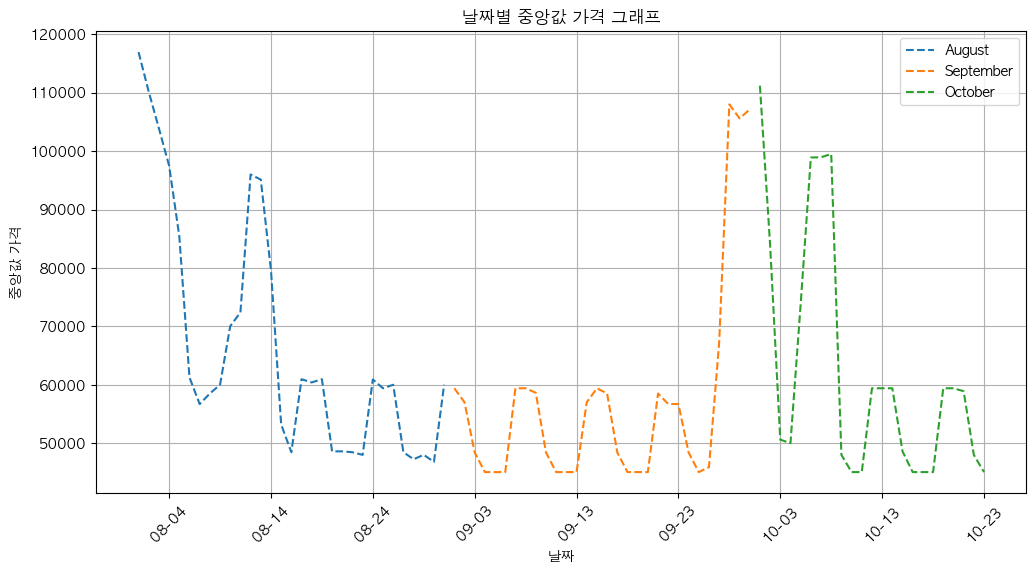

In [20]:
# date 날짜 형태로 바꾸기
df['date'] = pd.to_datetime(df['date'])

# month day 컬럼으로 월과 일만 받기
df['month_day'] = df['date'].dt.strftime('%m-%d')

# 8, 9, 10월 구간 설정
df_agt = df[(df['date'] >= '2023-08-01') & (df['date'] <= '2023-08-31')]
df_stp = df[(df['date'] >= '2023-09-01') & (df['date'] <= '2023-09-30')]
df_oct = df[(df['date'] >= '2023-10-01') & (df['date'] <= '2023-10-31')]

# 각 구간별 가격 중앙값 계산
med_agt = df_agt.groupby('month_day')['price'].median()
med_stp = df_stp.groupby('month_day')['price'].median()
med_oct = df_oct.groupby('month_day')['price'].median()

# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(med_agt.index, med_agt.values, label='August', linestyle='dashed')
plt.plot(med_stp.index, med_stp.values, label='September', linestyle='dashed')
plt.plot(med_oct.index, med_oct.values, label='October', linestyle='dashed')
plt.xlabel('날짜')
plt.ylabel('중앙값 가격')
plt.title('날짜별 중앙값 가격 그래프')

# 10일 마다 x축 표시
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))

plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

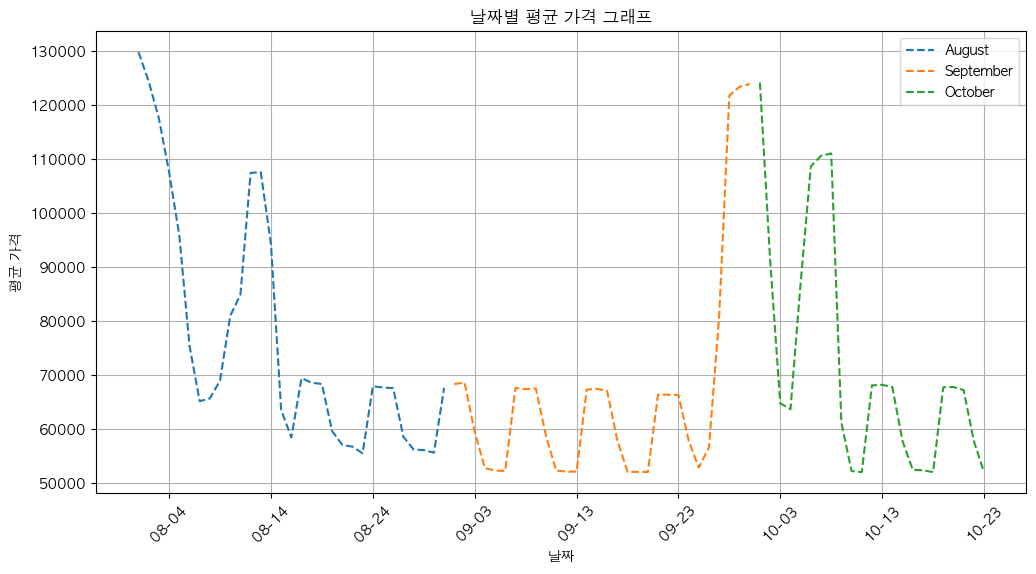

In [21]:
# date 날짜 형태로 바꾸기
df['date'] = pd.to_datetime(df['date'])

# month day 컬럼으로 월과 일만 받기
df['month_day'] = df['date'].dt.strftime('%m-%d')


# 각 구간별 가격 평균값 계산
avg_agt = df_agt.groupby('month_day')['price'].mean()
avg_stp = df_stp.groupby('month_day')['price'].mean()
avg_oct = df_oct.groupby('month_day')['price'].mean()

# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(avg_agt.index, avg_agt.values, label='August', linestyle='dashed')
plt.plot(avg_stp.index, avg_stp.values, label='September', linestyle='dashed')
plt.plot(avg_oct.index, avg_oct.values, label='October', linestyle='dashed')
plt.xlabel('날짜')
plt.ylabel('평균 가격')
plt.title('날짜별 평균 가격 그래프')

# 10일 마다 x축 표시
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))

plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [22]:
def divide_data_by_month(df, month):
    return df[df['month'] == month]

def limit(column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    amplitude = q3 - q1
    lower_bound, upper_bound = q1 - 1.5 * amplitude, q3 + 1.5 * amplitude
    return lower_bound, upper_bound


# Boxplot 함수
def boxplot(column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    amplitude = q3 - q1
    lower_bound, upper_bound = q1 - 1.5 * amplitude, q3 + 1.5 * amplitude

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)

    sns.boxplot(x=column, ax=ax1)

    sns.boxplot(x=column, ax=ax2)
    ax2.set_xlim(lower_bound, upper_bound)

    plt.show()

# Histogram 함수
def histogram(column, month_data):
    plt.figure(figsize=(8, 5))
    sns.histplot(data=month_data, x=column, kde=True)
    plt.title(f'Histogram - {column} (Month: {month_data["month"].iloc[0]})')
    plt.show()

# Violinplot 함수
def violinplot(column, month_data):
    day_order = ['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일']
    plt.figure(figsize=(12, 6))
    sns.violinplot(data=month_data, x='day', y=column, order=day_order, palette='cool', split=True)
    plt.title(f'Violin Plot - {column} (Month: {month_data["month"].iloc[0]})')
    plt.show()

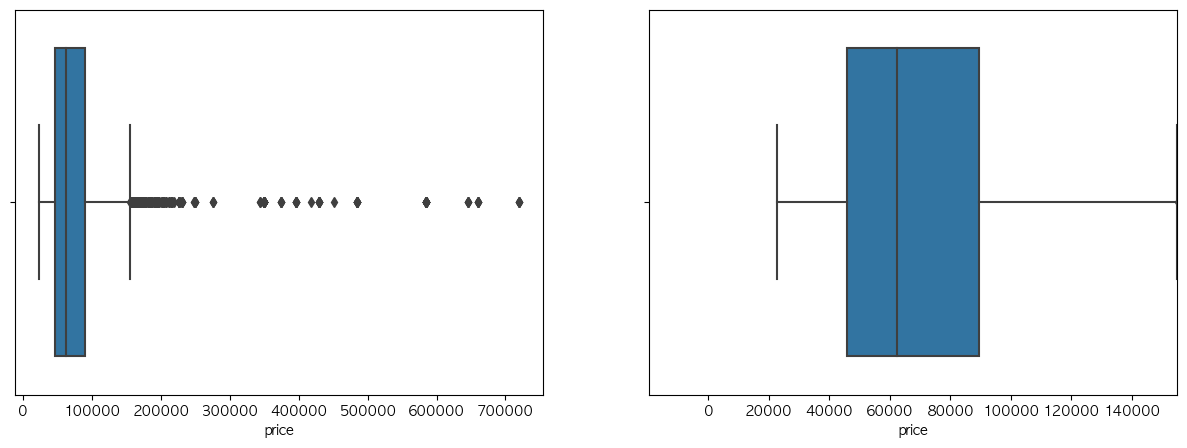

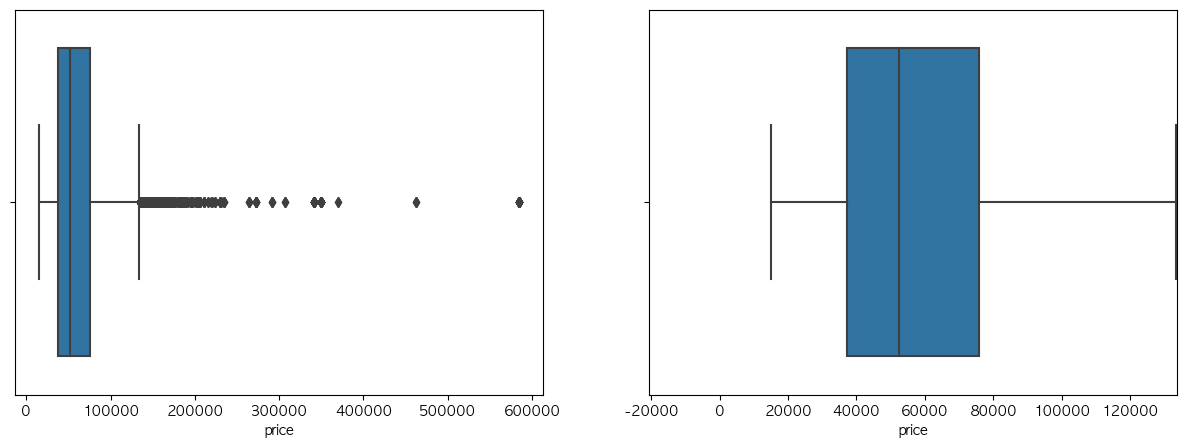

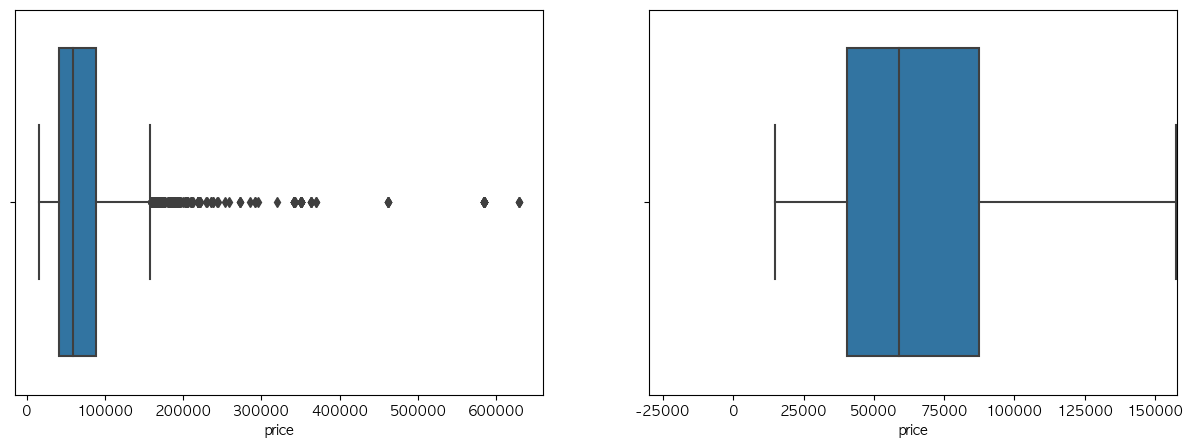

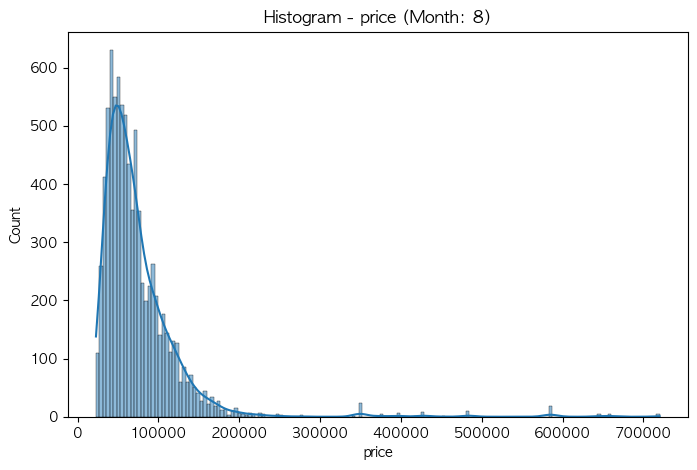

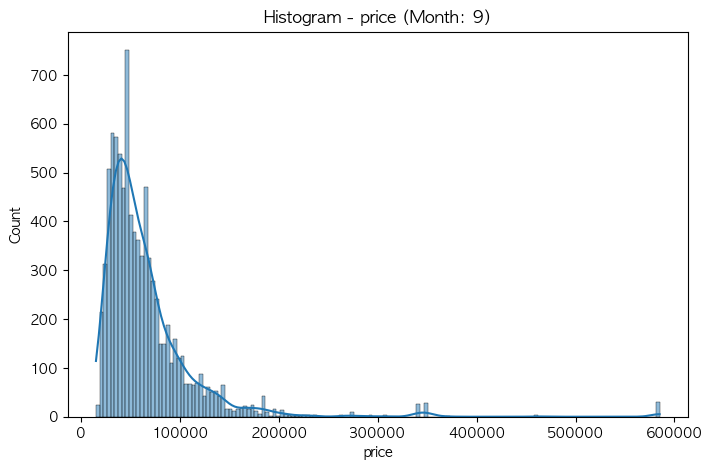

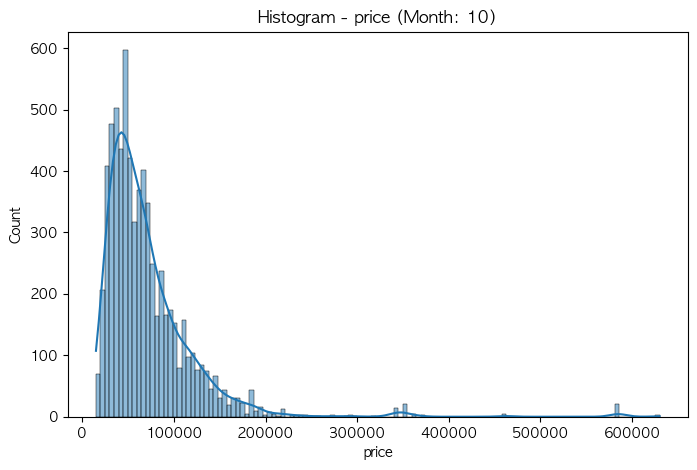

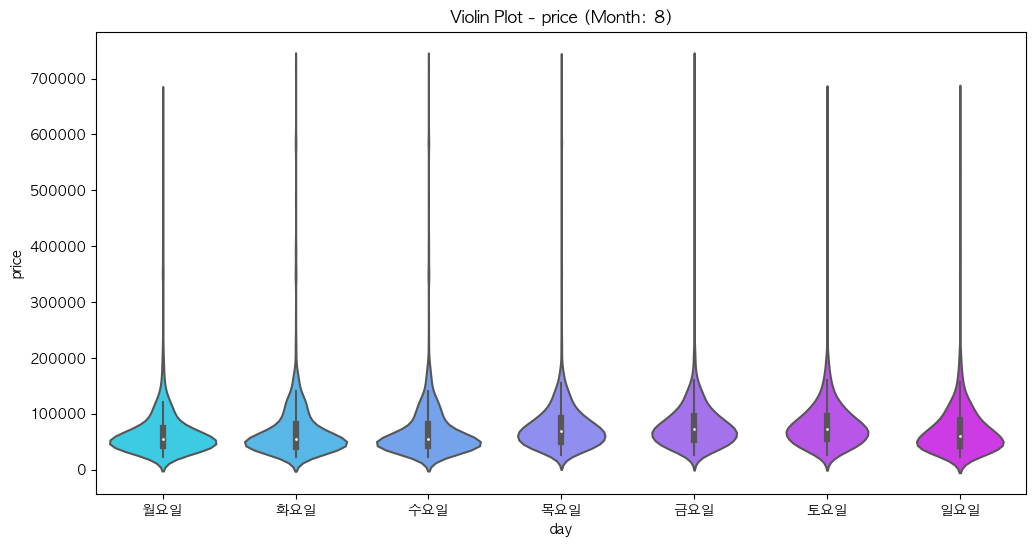

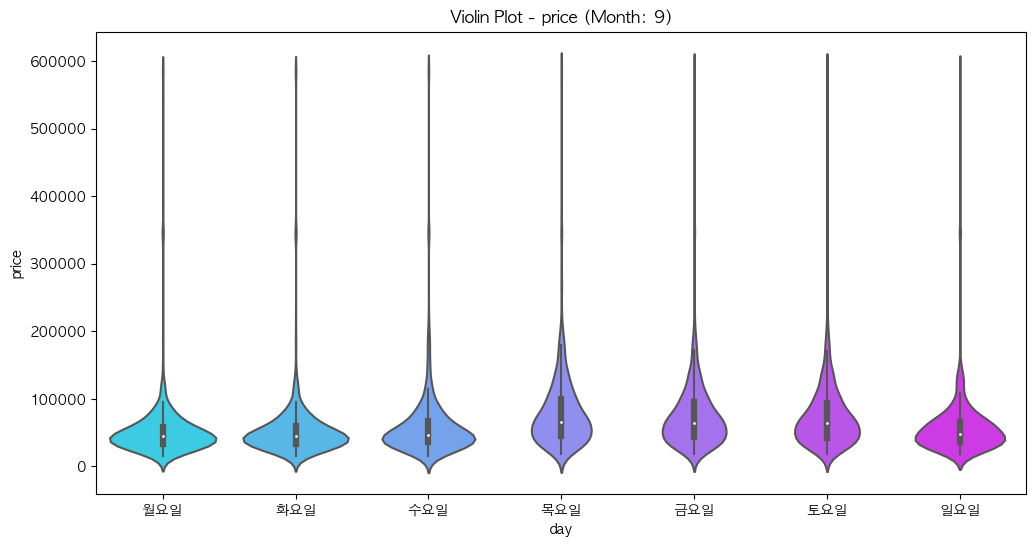

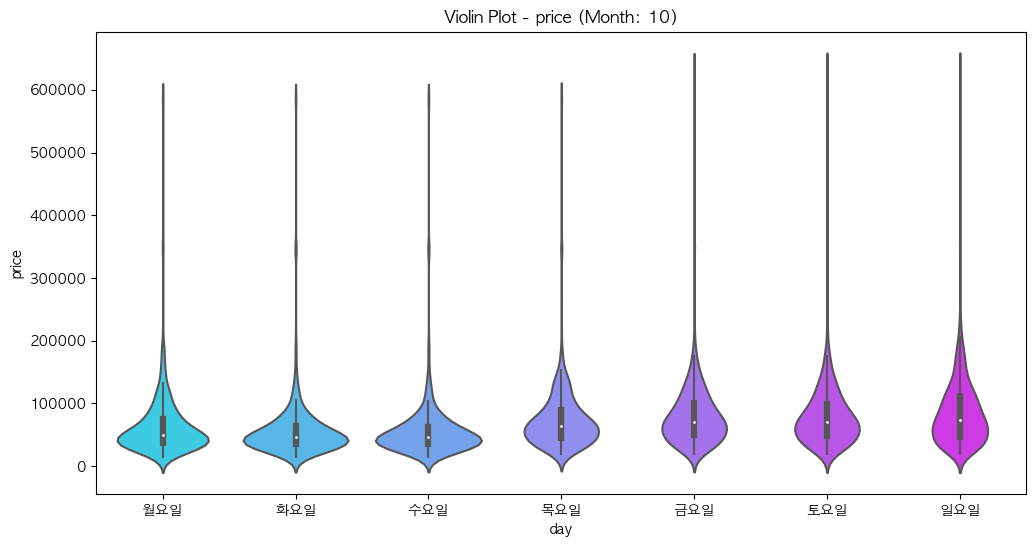

In [23]:
month_8_data = divide_data_by_month(df, 8)
month_9_data = divide_data_by_month(df, 9)
month_10_data = divide_data_by_month(df, 10)

# 월별 그래프 그리기
boxplot(month_8_data['price'])
boxplot(month_9_data['price'])
boxplot(month_10_data['price'])

histogram('price', month_8_data)
histogram('price', month_9_data)
histogram('price', month_10_data)

violinplot('price', month_8_data)
violinplot('price', month_9_data)
violinplot('price', month_10_data)

In [24]:
def excluir_outliers(df, nome_coluna):
    qtde_linhas = df.shape[0]

    lim_inf, lim_sup = limit(df[nome_coluna])

    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]

    linhas_removidas = qtde_linhas - df.shape[0]
    return df,  linhas_removidas

1093 linhas removidas


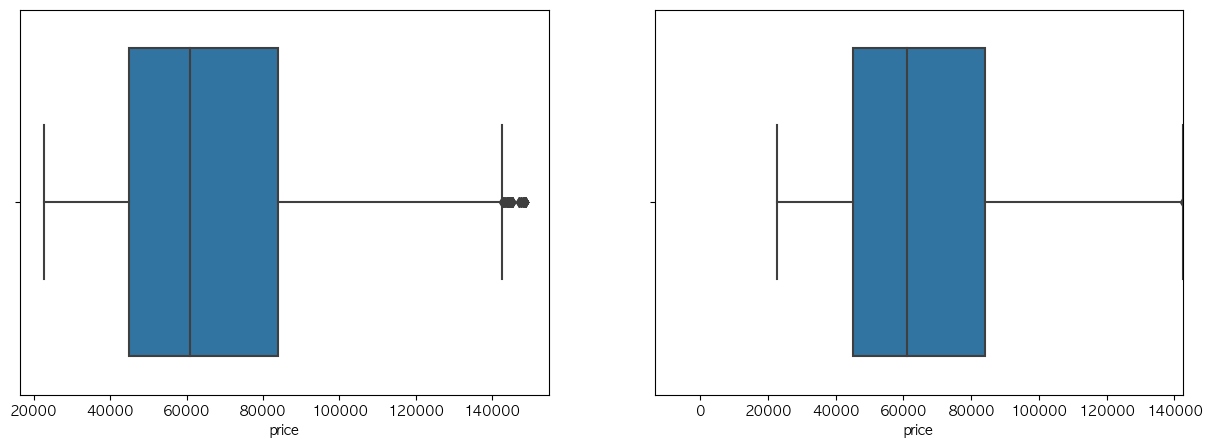

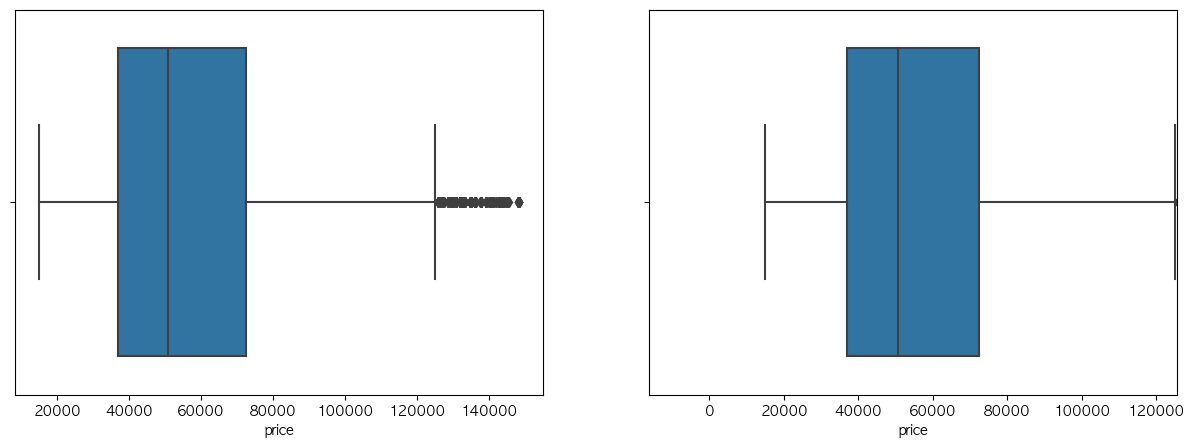

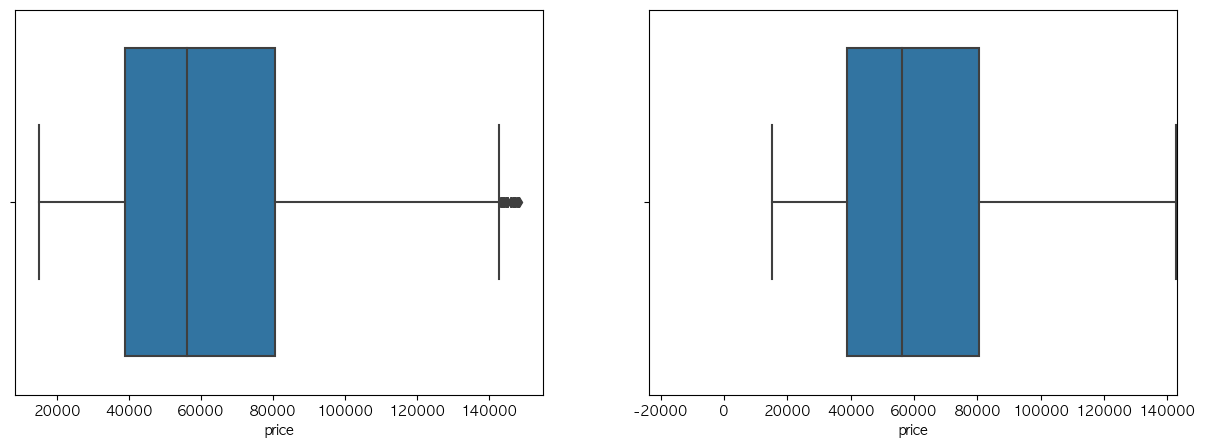

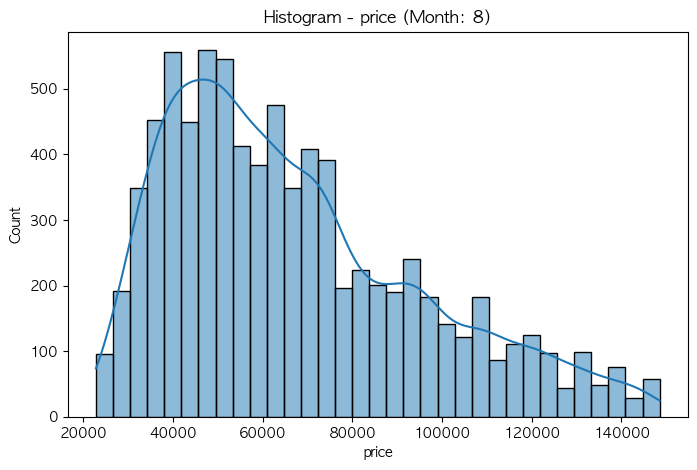

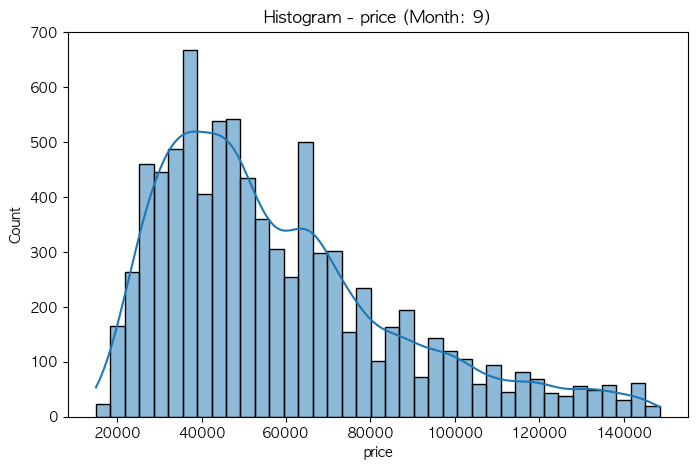

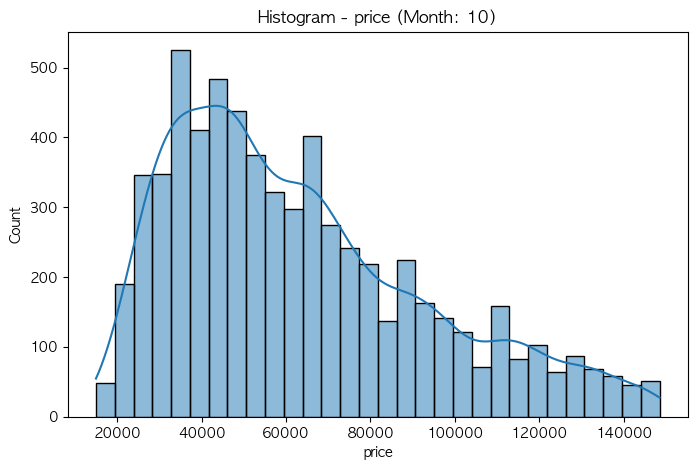

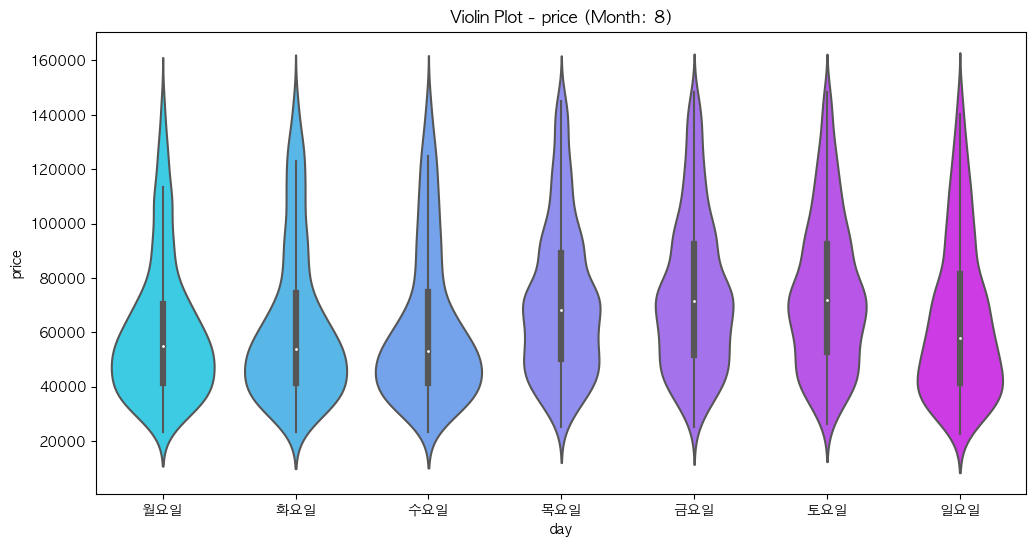

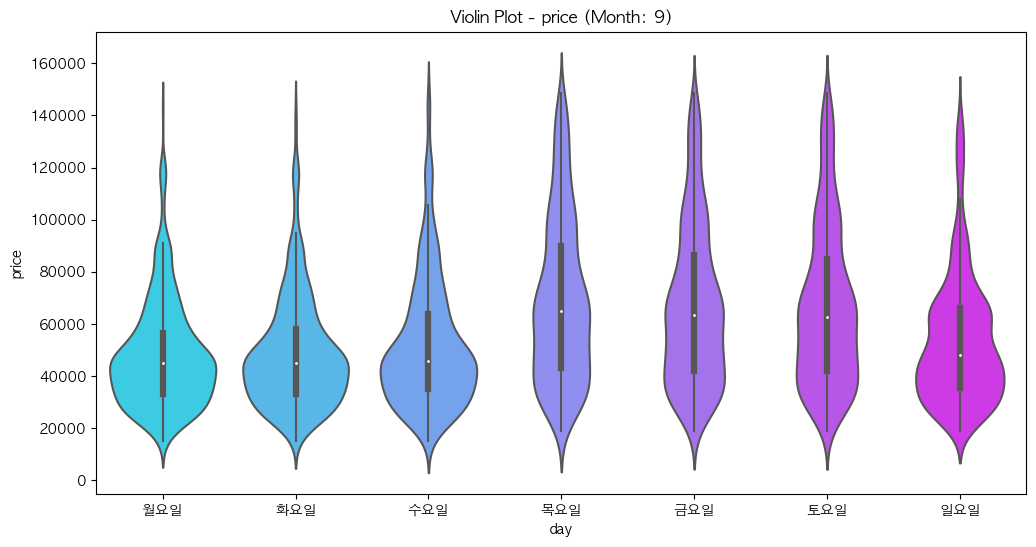

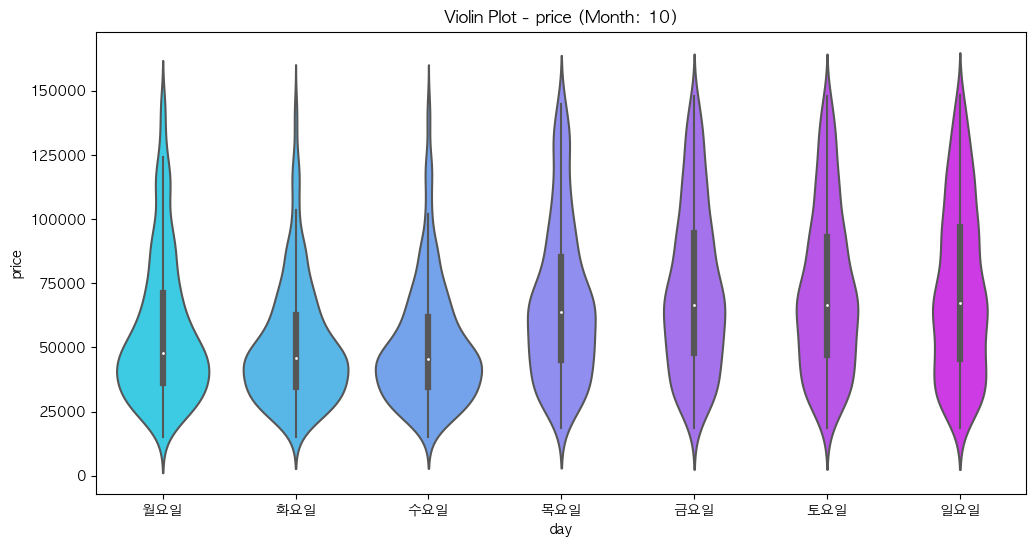

In [25]:
# 이상치 제거
df, linhas_removidas = excluir_outliers(df, 'price')
print('{} linhas removidas'.format(linhas_removidas))

# 월별 데이터 분할
month_8_data = divide_data_by_month(df, 8)
month_9_data = divide_data_by_month(df, 9)
month_10_data = divide_data_by_month(df, 10)

# 그래프 그리기
boxplot(month_8_data['price'])
boxplot(month_9_data['price'])
boxplot(month_10_data['price'])

histogram('price', month_8_data)
histogram('price', month_9_data)
histogram('price', month_10_data)

violinplot('price', month_8_data)
violinplot('price', month_9_data)
violinplot('price', month_10_data)

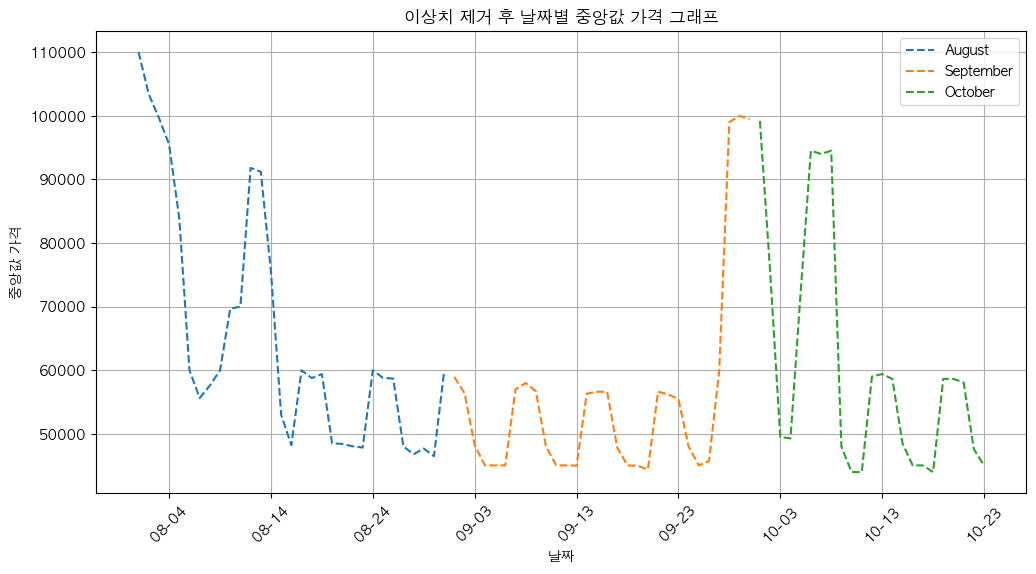

In [26]:
# date 날짜 형태로 바꾸기
df['date'] = pd.to_datetime(df['date'])

# month day 컬럼으로 월과 일만 받기
df['month_day'] = df['date'].dt.strftime('%m-%d')

# 8, 9, 10월 구간 설정
df_agt = df[(df['date'] >= '2023-08-01') & (df['date'] <= '2023-08-31')]
df_stp = df[(df['date'] >= '2023-09-01') & (df['date'] <= '2023-09-30')]
df_oct = df[(df['date'] >= '2023-10-01') & (df['date'] <= '2023-10-31')]

# 각 구간별 가격 중앙값 계산
med_agt = df_agt.groupby('month_day')['price'].median()
med_stp = df_stp.groupby('month_day')['price'].median()
med_oct = df_oct.groupby('month_day')['price'].median()

# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(med_agt.index, med_agt.values, label='August', linestyle='dashed')
plt.plot(med_stp.index, med_stp.values, label='September', linestyle='dashed')
plt.plot(med_oct.index, med_oct.values, label='October', linestyle='dashed')
plt.xlabel('날짜')
plt.ylabel('중앙값 가격')
plt.title('이상치 제거 후 날짜별 중앙값 가격 그래프')

# 10일 마다 x축 표시
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))

plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

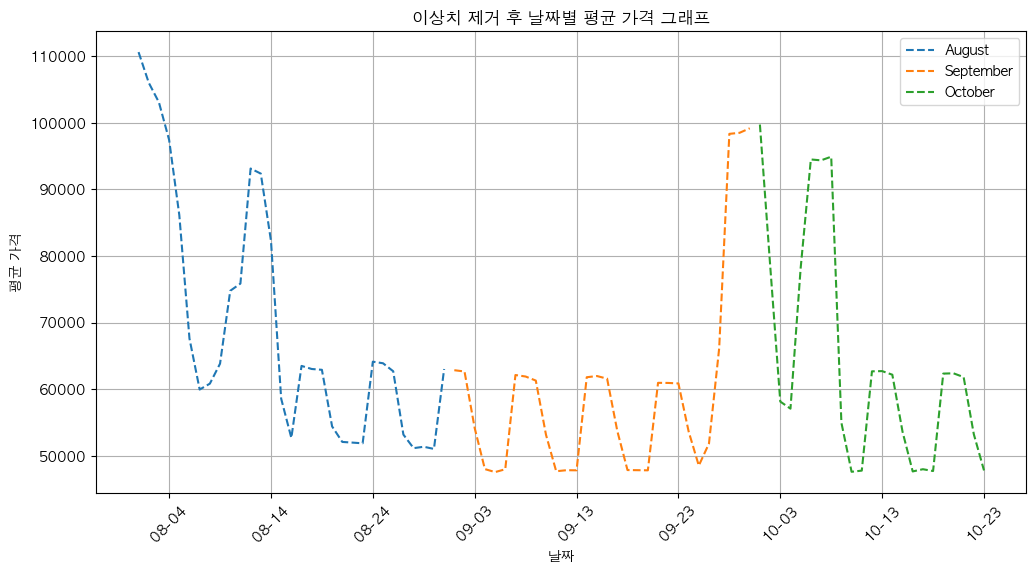

In [27]:
# date 날짜 형태로 바꾸기
df['date'] = pd.to_datetime(df['date'])

# month day 컬럼으로 월과 일만 받기
df['month_day'] = df['date'].dt.strftime('%m-%d')


# 각 구간별 가격 평균값 계산
avg_agt = df_agt.groupby('month_day')['price'].mean()
avg_stp = df_stp.groupby('month_day')['price'].mean()
avg_oct = df_oct.groupby('month_day')['price'].mean()

# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(avg_agt.index, avg_agt.values, label='August', linestyle='dashed')
plt.plot(avg_stp.index, avg_stp.values, label='September', linestyle='dashed')
plt.plot(avg_oct.index, avg_oct.values, label='October', linestyle='dashed')
plt.xlabel('날짜')
plt.ylabel('평균 가격')
plt.title('이상치 제거 후 날짜별 평균 가격 그래프')

# 10일 마다 x축 표시
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))

plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [28]:
df_ml = df.copy()
# 레이블 인코딩을 적용할 컬럼들 선택
columns_to_encode = ["name", "type", "seater", "holiday", 'label', 'day', 'peak_season', 'made', 'year_model', 'category']

# 라벨 인코더 생성 및 적용
label_encoders = {}
for column in columns_to_encode:
    label_encoder = LabelEncoder()
    df_ml[column] = label_encoder.fit_transform(df_ml[column])
    label_encoders[column] = label_encoder

# 인코딩 이전의 데이터와 인코딩된 후의 데이터 비교
for column in columns_to_encode:
    print(f"'{column}'")
    mapping = dict(zip(label_encoders[column].classes_, label_encoders[column].transform(label_encoders[column].classes_)))
    print(mapping)
    print()

'name'
{'3세대 K5': 0, '4세대 쏘렌토': 1, '4세대 투싼': 2, '4세대카니발': 3, 'BMW 420i 컨버터블': 4, 'BMW 428i 컨버터블': 5, 'BMW 430i 컨버터블': 6, 'BMW 520i': 7, 'BMW Z4': 8, 'EV6': 9, 'K5': 10, 'K7': 11, 'K7 프리미어': 12, 'K8': 13, 'LF쏘나타': 14, 'QM6': 15, 'QM6 LPE': 16, 'SM6': 17, 'XM3': 18, 'i30': 19, '그랜드스타렉스': 20, '그랜저IG': 21, '뉴K3': 22, '뉴SM3 ZE': 23, '니로': 24, '더 K9': 25, '더넥스트스파크': 26, '더뉴K5': 27, '더뉴그랜저': 28, '더뉴레이': 29, '더뉴모닝': 30, '더뉴모하비': 31, '더뉴스타렉스': 32, '더뉴스타렉스어반': 33, '더뉴싼타페': 34, '더뉴아반떼': 35, '더뉴카니발': 36, '더뉴카니발 하이리무진': 37, '더뉴카니발리무진': 38, '더뉴팰리세이드': 39, '디 올뉴코나': 40, '디올뉴그랜저': 41, '디올뉴스포티지': 42, '레이': 43, '모닝 어반': 44, '모하비더마스터': 45, '미니쿠퍼컨버터블': 46, '미니쿠퍼컨버터블 S': 47, '미니클럽맨': 48, '베뉴': 49, '베리뉴 티볼리': 50, '벤츠 C클래스 카브리올레': 51, '벤츠 E220d 카브리올레': 52, '벤츠 E250 아방가르드': 53, '볼보 XC40': 54, '볼트EV': 55, '셀토스': 56, '쉐보레 트래버스': 57, '스타렉스 하이리무진': 58, '스타리아': 59, '스토닉': 60, '스포티지': 61, '스포티지 더볼드': 62, '스포티지더볼드': 63, '싼타페TM': 64, '쏘나타': 65, '쏘나타 DN8': 66, '쏘나타 디 엣지': 67, '쏘나타뉴라이즈': 68, '쏘렌토': 69, '쏘울 부스터': 70, '쏠

In [29]:
X = df_ml.drop(['price', 'year', 'month', 'days', 'month_day', 'date', 'm_year', 'name','type','label', 'year_model', 'r_rate'], axis=1)
y = df_ml['price']

# train과 test 랜덤하게 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤포레스트 모델 학습
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# XGBoost 모델 학습
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

# CatBoost 모델 학습
catboost_model = CatBoostRegressor(random_state=42, verbose=False)
catboost_model.fit(X_train, y_train)

# 선형 회귀 모델 학습
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# 랜덤포레스트 모델 예측
y_test_pred_rf = rf_model.predict(X_test)

# XGBoost 모델 예측
y_test_pred_xgb = xgb_model.predict(X_test)

# CatBoost 모델 예측
y_test_pred_catboost = catboost_model.predict(X_test)

# 선형 회귀 모델 예측
y_test_pred_linear = linear_model.predict(X_test)

In [30]:
column_list = X_train.columns.tolist()
print(column_list)

['seater', 'made', 'category', 'day', 'holiday', 'peak_season']


In [31]:
feature_importances = xgb_model.feature_importances_

importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

       Feature  Importance
5  peak_season    0.253335
2     category    0.232869
1         made    0.209216
0       seater    0.186442
4      holiday    0.091981
3          day    0.026158


In [32]:
def eval_models(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred).round(3)
    rmse = np.sqrt(mse).round(3)
    mae = mean_absolute_error(y_true, y_pred).round(3)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, r2

In [33]:
# 랜덤포레스트 성능 확인
comparison_rf = pd.DataFrame(index=['mse', 'rmse', 'mae', 'r2'], columns=['Base', 'Train', 'Test'])
baseline = [y_train.mean()] * len(y_train)
comparison_rf['Base'] = eval_models(y_train, baseline)
comparison_rf['Train'] = eval_models(y_train, rf_model.predict(X_train))
comparison_rf['Test'] = eval_models(y_test, y_test_pred_rf)

# XGBoost 성능 확인
comparison_xgb = pd.DataFrame(index=['mse', 'rmse', 'mae', 'r2'], columns=['Base', 'Train', 'Test'])
comparison_xgb['Base'] = eval_models(y_train, baseline)
comparison_xgb['Train'] = eval_models(y_train, xgb_model.predict(X_train))
comparison_xgb['Test'] = eval_models(y_test, y_test_pred_xgb)

# CatBoost 성능 확인
comparison_catboost = pd.DataFrame(index=['mse', 'rmse', 'mae', 'r2'], columns=['Base', 'Train', 'Test'])
comparison_catboost['Base'] = eval_models(y_train, baseline)
comparison_catboost['Train'] = eval_models(y_train, catboost_model.predict(X_train))
comparison_catboost['Test'] = eval_models(y_test, y_test_pred_catboost)

# 선형 회귀 모델 성능 확인
comparison_linear = pd.DataFrame(index=['mse', 'rmse', 'mae', 'r2'], columns=['Base', 'Train', 'Test'])
comparison_linear['Base'] = eval_models(y_train, baseline)
comparison_linear['Train'] = eval_models(y_train, linear_model.predict(X_train))
comparison_linear['Test'] = eval_models(y_test, y_test_pred_linear)

In [34]:
pd.options.display.float_format = '{:,.2f}'.format
print("Random Forest 예측 성능:")
comparison_rf

Random Forest 예측 성능:


,Base,Train,Test
mse,"845,252,964.42","262,079,545.28","272,650,056.04"
rmse,"29,073.24","16,188.87","16,512.12"
mae,"23,326.23","11,651.23","11,876.73"
r2,0.00,0.69,0.68


In [35]:
print("\nXGBoost 예측 성능:")
comparison_xgb


XGBoost 예측 성능:


,Base,Train,Test
mse,"845,252,964.42","262,223,367.65","272,202,354.40"
rmse,"29,073.24","16,193.31","16,498.56"
mae,"23,326.23","11,653.03","11,858.96"
r2,0.00,0.69,0.68


In [36]:
print("\nCatboost 예측 성능:")
comparison_catboost


Catboost 예측 성능:


,Base,Train,Test
mse,"845,252,964.42","262,925,064.30","270,281,812.42"
rmse,"29,073.24","16,214.96","16,440.25"
mae,"23,326.23","11,687.87","11,846.19"
r2,0.00,0.69,0.68


In [37]:
print("\n선형회귀 예측 성능:")
comparison_linear


선형회귀 예측 성능:


,Base,Train,Test
mse,"845,252,964.42","575,951,467.91","570,398,989.51"
rmse,"29,073.24","23,998.99","23,883.03"
mae,"23,326.23","18,470.87","18,483.26"
r2,0.00,0.32,0.33


In [38]:
def get_weekday(date):
    day = ['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일']
    return day[date.weekday()]

def is_weekend_or_holiday(date, holiday_list):
    if date.weekday() >= 5:
        return "주말"
    elif date.strftime('%Y-%m-%d') in holiday_list:
        return "공휴일"
    else:
        return "평일"

def is_peak_season(date, peak_seasons):
    for peak_start, peak_end in peak_seasons:
        if peak_start <= date <= peak_end:
            return '성수기'
    return '비수기'

# 8월부터 12월까지의 날짜 어레이 리스트를 만듭니다.
start_date = pd.to_datetime('2023-08-01')
end_date = pd.to_datetime('2023-12-31')
date_array = pd.date_range(start_date, end_date)

# 성수기 기간 
peak_seasons = [
    (datetime.date(2023, 8, 1), datetime.date(2023, 8, 15)),  # 8월 성수기
    (datetime.date(2023, 9, 26), datetime.date(2023, 9, 30)),  # 9월 성수기
    (datetime.date(2023, 10, 1), datetime.date(2023, 10, 2)),  # 10월 성수기
    (datetime.date(2023, 10, 6), datetime.date(2023, 10, 9)),  # 10월 성수기
    (datetime.date(2023, 12, 22), datetime.date(2023, 12, 25)),   # 12월 성수기
    (datetime.date(2023, 12, 29), datetime.date(2023, 12, 31))     # 12월 성수기
]

# 공휴일 리스트
holiday_list = ['2023-08-15', '2023-09-28', '2023-09-29', '2023-09-30', '2023-10-03', '2023-10-09', '2023-12-25']

results = {}

for date in date_array:
    day = get_weekday(date)
    weekend_or_holiday = is_weekend_or_holiday(date.date(), holiday_list)
    peak_season = is_peak_season(date.date(), peak_seasons)
    
    # 딕셔너리에 결과 저장
    results[date.date()] = {
        'day': day,
        'holiday': weekend_or_holiday,
        'peak_season': peak_season
    }

print(results)

# XGBoost 클래스
class Rent:
    def __init__(self, xgb_model):
        self.xgb_model = xgb_model
        self.feature_list = ['made', 'category', 'day', 'holiday', 'peak_season']
        self.made_mapping = {'국산차': 0, '외제차': 1}
        self.category_mapping = {'경차': 0, '대형SUV': 1, '대형차': 2, '소형SUV': 3, '소형차': 4, '스포츠카': 5, '승합차': 6, '준대형': 7, '준중형': 8, '중형SUV': 9, '중형차': 10}
        self.day_mapping = {'금요일': 0, '목요일': 1, '수요일': 2, '월요일': 3, '일요일': 4, '토요일': 5, '화요일': 6}
        self.holiday_mapping = {'공휴일': 0, '주말': 1, '평일': 2}
        self.peak_season_mapping = {'비수기': 0, '성수기': 1}

rent_model = Rent(xgb_model)

# 모델을 pickle 파일로 저장
with open('xgb_model_rent.pkl', 'wb') as file:
    pickle.dump(rent_model, file)

# 저장된 pickle 파일로부터 모델 불러오기
with open('xgb_model_rent.pkl', 'rb') as file:
    loaded_flight_model = pickle.load(file)

{datetime.date(2023, 8, 1): {'day': '화요일', 'holiday': '평일', 'peak_season': '성수기'}, datetime.date(2023, 8, 2): {'day': '수요일', 'holiday': '평일', 'peak_season': '성수기'}, datetime.date(2023, 8, 3): {'day': '목요일', 'holiday': '평일', 'peak_season': '성수기'}, datetime.date(2023, 8, 4): {'day': '금요일', 'holiday': '평일', 'peak_season': '성수기'}, datetime.date(2023, 8, 5): {'day': '토요일', 'holiday': '주말', 'peak_season': '성수기'}, datetime.date(2023, 8, 6): {'day': '일요일', 'holiday': '주말', 'peak_season': '성수기'}, datetime.date(2023, 8, 7): {'day': '월요일', 'holiday': '평일', 'peak_season': '성수기'}, datetime.date(2023, 8, 8): {'day': '화요일', 'holiday': '평일', 'peak_season': '성수기'}, datetime.date(2023, 8, 9): {'day': '수요일', 'holiday': '평일', 'peak_season': '성수기'}, datetime.date(2023, 8, 10): {'day': '목요일', 'holiday': '평일', 'peak_season': '성수기'}, datetime.date(2023, 8, 11): {'day': '금요일', 'holiday': '평일', 'peak_season': '성수기'}, datetime.date(2023, 8, 12): {'day': '토요일', 'holiday': '주말', 'peak_season': '성수기'}, datetime.dat

In [39]:
# 저장할 경로 변경
os.chdir("model")

# 모델을 파일에 피클링하여 저장
with open('xgb_model_rent.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)

# 저장된 피클 파일로부터 모델 불러오기
with open('xgb_model_rent.pkl', 'rb') as file:
    loaded_xgb_model = pickle.load(file)

In [40]:
# 예측값을 테스트 데이터에 해당하는 행에만 추가
df_ml.loc[X_test.index, 'Predicted_Price'] = y_test_pred_xgb

# 나머지 행 삭제
df_ml.dropna(subset=['Predicted_Price'], inplace=True)

# 결과 확인
display(df_ml)

,date,name,type,seater,m_year,price,label,year_model,made,category,r_rate,day,holiday,year,month,days,peak_season,month_day,Predicted_Price
3,2023-08-01,79,4,2,2022,87220,0,1,0,8,3,6,2,2023,8,1,1,08-01,"44,822.35"
17,2023-08-01,27,4,2,2018,99960,0,5,0,10,3,6,2,2023,8,1,1,08-01,"62,023.07"
31,2023-08-01,79,4,2,2022,108580,0,1,0,8,3,6,2,2023,8,1,1,08-01,"44,822.35"
34,2023-08-01,10,4,2,2022,112200,0,1,0,10,1,6,2,2023,8,1,1,08-01,"62,023.07"
35,2023-08-01,16,0,2,2020,112200,0,3,0,9,3,6,2,2023,8,1,1,08-01,"68,279.49"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24064,2023-10-23,47,4,1,2021,63000,1,2,1,4,1,3,2,2023,10,23,0,10-23,"64,789.51"
24068,2023-10-23,59,1,7,2022,64800,1,1,0,6,1,3,2,2023,10,23,0,10-23,"67,419.99"
24086,2023-10-23,6,4,1,2020,87400,1,3,1,8,1,3,2,2023,10,23,0,10-23,"87,750.81"
24087,2023-10-23,54,4,2,2022,87400,1,1,1,9,1,3,2,2023,10,23,0,10-23,"95,957.17"


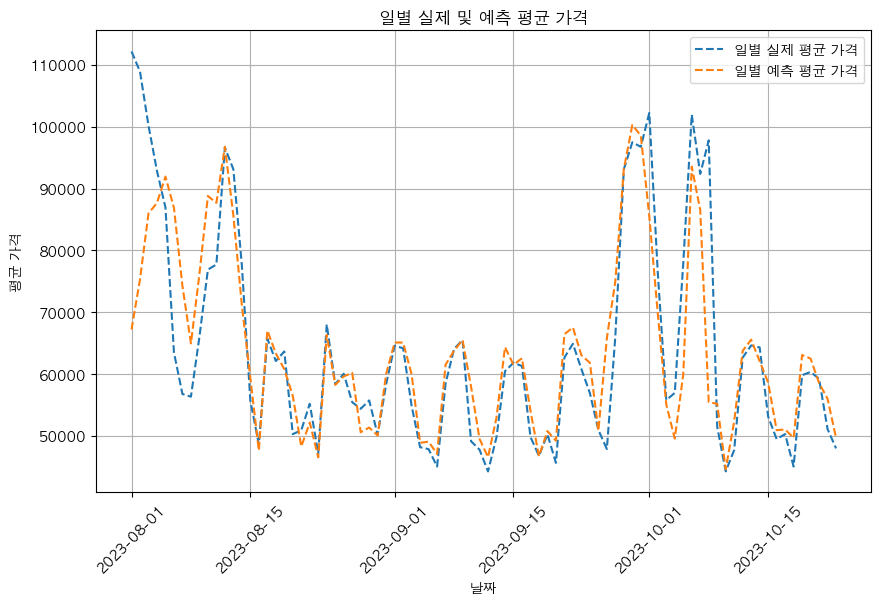

In [41]:
# 실제 가격과 날짜 컬럼만 추출
df_actual_prices = df_ml[['price', 'date']].copy()

# 날짜 컬럼을 datetime 형식으로 변환
df_actual_prices['date'] = pd.to_datetime(df_actual_prices['date'])

# 날짜별 실제 평균 가격 계산
daily_actual_avg_prices = df_actual_prices.groupby('date')['price'].mean().reset_index()

# 점선 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(daily_actual_avg_prices['date'], daily_actual_avg_prices['price'], '--', label='일별 실제 평균 가격')

# 예측 가격과 날짜 컬럼만 추출
df_predicted_prices = df_ml[['Predicted_Price', 'date']].copy()

# 날짜 컬럼을 datetime 형식으로 변환
df_predicted_prices['date'] = pd.to_datetime(df_predicted_prices['date'])

# 날짜별 예측 평균 가격 계산
daily_predicted_avg_prices = df_predicted_prices.groupby('date')['Predicted_Price'].mean().reset_index()

# 예측 가격 그래프 그리기
plt.plot(daily_predicted_avg_prices['date'], daily_predicted_avg_prices['Predicted_Price'], '--', label='일별 예측 평균 가격')

plt.xlabel('날짜')
plt.ylabel('평균 가격')
plt.title('일별 실제 및 예측 평균 가격')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()